# Análisis de Bigramas en Hipnogramas del Sueño

Este notebook proporciona un análisis completo de **bigramas** (transiciones entre etapas consecutivas) en hipnogramas del sueño.

## ¿Qué son los Bigramas?

Los **bigramas** son pares consecutivos de etapas del sueño que capturan las **transiciones** entre distintas fases del sueño.

### Ejemplo:
Para el hipnograma: **[7, 7, 0, 1, 2, 2, 3]**

Los bigramas serían:
- **7→7** (Sin clasificar → Sin clasificar)
- **7→0** (Sin clasificar → Vigilia)
- **0→1** (Vigilia → N1)
- **1→2** (N1 → N2)
- **2→2** (N2 → N2, persistencia en la misma etapa)
- **2→3** (N2 → N3, progresión al sueño profundo)

---

## Fórmulas Matemáticas

### Número de Bigramas

Para un hipnograma de longitud $n$:
$$\text{Número de bigramas} = n - 1$$

### Frecuencia de Bigramas

La frecuencia de un bigrama $(etapa_1 \to etapa_2)$ es:
$$f(etapa_1 \to etapa_2) = \frac{\text{count}(etapa_1 \to etapa_2)}{\text{total de bigramas}}$$

### Probabilidad de Transición

La probabilidad de transición de $etapa_1$ a $etapa_2$ es:
$$P(etapa_2 | etapa_1) = \frac{f(etapa_1 \to etapa_2)}{\sum_{t} f(etapa_1 \to t)}$$

Esto representa una **cadena de Markov de primer orden**, donde la probabilidad de la siguiente etapa depende solo de la etapa actual.

---

## Uso del Notebook

Simplemente ejecuta todas las celdas y luego llama a:
```python
resultados = generar_reporte_completo("AR_2")
```


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

## Definición de Funciones


In [3]:
def cargar_hipnograma(archivo):
    """Carga hipnograma y extrae columna de validación"""
    df = pd.read_csv(archivo, sep='\s+', header=None, names=['epoch', 'scor_clean', 'scor_quasi'])
    return df['scor_clean'].tolist()

def extraer_bigramas(hipnograma):
    """Extrae bigramas (pares consecutivos de etapas)"""
    bigramas = []
    bigramas_str = []
    for i in range(len(hipnograma) - 1):
        bg = (hipnograma[i], hipnograma[i+1])
        bigramas.append(bg)
        bigramas_str.append(f"{hipnograma[i]}→{hipnograma[i+1]}")
    return bigramas, bigramas_str, len(bigramas)

def calcular_frecuencias_bigramas(bigramas):
    """Calcula frecuencias y probabilidades"""
    contador = Counter(bigramas)
    total = len(bigramas)
    df = pd.DataFrame([
        {'Transición': f"{bg[0]}→{bg[1]}", 'Desde': bg[0], 'Hacia': bg[1], 
         'Frecuencia': count, 'Probabilidad': count/total}
        for bg, count in contador.items()
    ])
    return contador, df.sort_values('Frecuencia', ascending=False)

def crear_matriz_transiciones(bigramas):
    """Crea matriz de Markov con probabilidades"""
    contador = Counter(bigramas)
    etapas = sorted(set([item for sublist in bigramas for item in sublist]))
    matriz_abs = pd.DataFrame(0, index=etapas, columns=etapas, dtype=int)
    for (desde, hacia), count in contador.items():
        matriz_abs.loc[desde, hacia] = count
    matriz_prob = matriz_abs.div(matriz_abs.sum(axis=1), axis=0).fillna(0)
    return matriz_abs, matriz_prob

def visualizar_matriz(matriz_prob, titulo):
    """Visualiza matriz con heatmap"""
    mapa = {0: 'Vigilia (W)', 1: 'N1', 2: 'N2', 3: 'N3', 
            4: 'N4', 5: 'REM', 6: 'Movimiento', 7: 'Sin clasificar'}
    labels = [mapa.get(e, f'Etapa {e}') for e in matriz_prob.index.tolist()]
    plt.figure(figsize=(14, 10))
    sns.heatmap(matriz_prob, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=labels, yticklabels=labels, linewidths=0.5)
    plt.title(f'{titulo}\\nP(etapa siguiente | etapa actual)', fontsize=14, fontweight='bold')
    plt.ylabel('Etapa Actual', fontsize=12)
    plt.xlabel('Etapa Siguiente', fontsize=12)
    plt.tight_layout()
    plt.show()

def mostrar_distribucion(hipnograma):
    """Muestra distribución de etapas"""
    dist = Counter(hipnograma)
    df = pd.DataFrame([
        {'Etapa': k, 'Frecuencia': v, 'Porcentaje': v/len(hipnograma)*100} 
        for k, v in sorted(dist.items())
    ])
    nombres = {0: 'Vigilia', 1: 'N1', 2: 'N2', 3: 'N3', 
               4: 'N4', 5: 'REM', 6: 'Movimiento', 7: 'Sin clasificar'}
    print("DISTRIBUCIÓN DE ETAPAS:")
    print(df.to_string(index=False))
    print("\nEtiquetas:")
    for etapa, nombre in nombres.items():
        if etapa in dist:
            print(f"  {etapa}: {nombre}")

def procesar_todos_pacientes(ruta_datos='../Datos'):
    """
    Procesa todos los pacientes con archivos _2 y retorna datos consolidados
    
    Args:
        ruta_datos: Ruta donde están los archivos de datos
    
    Returns:
        dict con:
            - 'dataframe_metricas': DataFrame con métricas por paciente
            - 'datos_completos': Dict con datos completos por paciente
            - 'matriz_promedio': Matriz de transición promedio de todos los pacientes
            - 'bigramas_todos': Lista de todos los bigramas (para entrenar Word2Vec)
    """
    import os
    
    # Encontrar todos los pacientes
    archivos = [f for f in os.listdir(ruta_datos) if f.startswith('Scoring_') and f.endswith('_2')]
    pacientes_ids = sorted([f.replace('Scoring_', '').replace('_2', '') for f in archivos])
    
    datos_completos = {}
    lista_metricas = []
    bigramas_todos = []
    
    print(f"Procesando {len(pacientes_ids)} pacientes...")
    
    for paciente_id in pacientes_ids:
        archivo = f'{ruta_datos}/Scoring_{paciente_id}_2'
        
        try:
            # Cargar y procesar
            hipnograma = cargar_hipnograma(archivo)
            bigramas, _, num_big = extraer_bigramas(hipnograma)
            contador, df_freq = calcular_frecuencias_bigramas(bigramas)
            mat_abs, mat_prob = crear_matriz_transiciones(bigramas)
            dist = Counter(hipnograma)
            
            # Acumular bigramas para Word2Vec
            bigramas_todos.extend(bigramas)
            
            # Extraer métricas principales
            metricas = {
                'Paciente': paciente_id,
                'Épocas': len(hipnograma),
                'Duración_min': len(hipnograma)*0.5,
                'Bigramas': num_big,
                'Transiciones_únicas': len(contador),
                'Etapa_0': dist.get(0, 0),
                'Etapa_1': dist.get(1, 0),
                'Etapa_2': dist.get(2, 0),
                'Etapa_3': dist.get(3, 0),
                'Etapa_4': dist.get(4, 0),
                'Etapa_5': dist.get(5, 0),
                'Etapa_6': dist.get(6, 0),
                'Etapa_7': dist.get(7, 0),
            }
            
            # Porcentajes
            total = len(hipnograma)
            for etapa in range(8):
                metricas[f'Porc_Etapa_{etapa}'] = (dist.get(etapa, 0) / total) * 100 if total > 0 else 0
            
            # Transición más frecuente
            if len(df_freq) > 0:
                top_trans = df_freq.iloc[0]
                metricas['Transición_más_freq'] = top_trans['Transición']
                metricas['Freq_top_trans'] = top_trans['Frecuencia']
                metricas['Prob_top_trans'] = top_trans['Probabilidad']
            
            lista_metricas.append(metricas)
            
            # Guardar datos completos
            datos_completos[paciente_id] = {
                'hipnograma': hipnograma,
                'bigramas': bigramas,
                'contador': contador,
                'df_frecuencias': df_freq,
                'matriz_absoluta': mat_abs,
                'matriz_probabilidades': mat_prob,
                'distribucion': dict(dist)
            }
            
            print(f"  ✓ {paciente_id}")
            
        except Exception as e:
            print(f"  ✗ Error en {paciente_id}: {e}")
            continue
    
    # Crear DataFrame de métricas
    df_metricas = pd.DataFrame(lista_metricas)
    
    # Calcular matriz promedio
    if datos_completos:
        etapas = sorted(set([item for paciente in datos_completos.values() 
                            for item in paciente['matriz_probabilidades'].index]))
        matriz_promedio = pd.DataFrame(0.0, index=etapas, columns=etapas)
        
        for paciente_data in datos_completos.values():
            mat_prob = paciente_data['matriz_probabilidades']
            # Alinear matrices (por si algún paciente no tiene todas las etapas)
            for i in etapas:
                for j in etapas:
                    if i in mat_prob.index and j in mat_prob.columns:
                        matriz_promedio.loc[i, j] += mat_prob.loc[i, j]
        
        # Promediar
        matriz_promedio = matriz_promedio / len(datos_completos)
    else:
        matriz_promedio = None
    
    print(f"\nProcesamiento completado: {len(datos_completos)} pacientes")
    
    return {
        'dataframe_metricas': df_metricas,
        'datos_completos': datos_completos,
        'matriz_promedio': matriz_promedio,
        'bigramas_todos': bigramas_todos,
        'num_pacientes': len(datos_completos)
    }

def generar_reporte_completo(paciente):
    """Genera reporte completo para un paciente"""
    archivo = f'../Datos/Scoring_{paciente}'
    print(f"ANÁLISIS DE BIGRAMAS: PACIENTE {paciente}")
    
    # Cargar
    hipnograma = cargar_hipnograma(archivo)
    print(f"{len(hipnograma)} épocas ({len(hipnograma)*0.5:.1f} min)\n")
    
    # Distribución
    mostrar_distribucion(hipnograma)
    
    # Bigramas
    bigramas, bigramas_str, num_big = extraer_bigramas(hipnograma)
    print(f"{num_big} bigramas (n-1)\n")
    
    # Frecuencias (todas las transiciones)
    contador, df_freq = calcular_frecuencias_bigramas(bigramas)
    print(f"{len(df_freq)} transiciones únicas\n")
    print("TABLA DE FRECUENCIAS (TODAS)\n")
    print(df_freq.to_string(index=False))
    
    # Matrices
    mat_abs, mat_prob = crear_matriz_transiciones(bigramas)
    print("\nMATRIZ DE TRANSICIONES (Valores Absolutos)\n")
    print(mat_abs)
    
    # Matriz de Probabilidades
    print("\nMATRIZ DE PROBABILIDADES\n")
    print("Interpretación: P(etapa siguiente | etapa actual)\n")
    print("Filas = actual, Columnas = siguiente\n")
    print(mat_prob.round(3))
    
    # Visualizar
    visualizar_matriz(mat_prob, f'Paciente {paciente}: Matriz de Probabilidades')
    
    # Resumen (sin repetir distribución ni transiciones)
    print(f"\nPaciente: {paciente}")
    print(f"Épocas: {len(hipnograma)} | Bigramas: {len(bigramas)} | Transiciones: {len(contador)}")
    
    return {
        'paciente': paciente, 'hipnograma': hipnograma, 'bigramas': bigramas,
        'contador': contador, 'df_frecuencias': df_freq,
        'matriz_absoluta': mat_abs, 'matriz_probabilidades': mat_prob
    }

Analizo un paciente llamando a la función **generar_reporte_completo()**:

ANÁLISIS DE BIGRAMAS: PACIENTE DG_2
1055 épocas (527.5 min)

DISTRIBUCIÓN DE ETAPAS:
 Etapa  Frecuencia  Porcentaje
     0          52    4.928910
     1          47    4.454976
     2         458   43.412322
     3          54    5.118483
     4          77    7.298578
     5         211   20.000000
     6          61    5.781991
     7          95    9.004739

Etiquetas:
  0: Vigilia
  1: N1
  2: N2
  3: N3
  4: N4
  5: REM
  6: Movimiento
  7: Sin clasificar
1054 bigramas (n-1)

34 transiciones únicas

TABLA DE FRECUENCIAS (TODAS)

Transición  Desde  Hacia  Frecuencia  Probabilidad
       2→2      2      2         401      0.380455
       5→5      5      5         189      0.179317
       7→7      7      7          94      0.089184
       4→4      4      4          60      0.056926
       0→0      0      0          39      0.037002
       2→3      2      3          26      0.024668
       6→6      6      6          23      0.021822
       1→1      1      1          22      0.020873


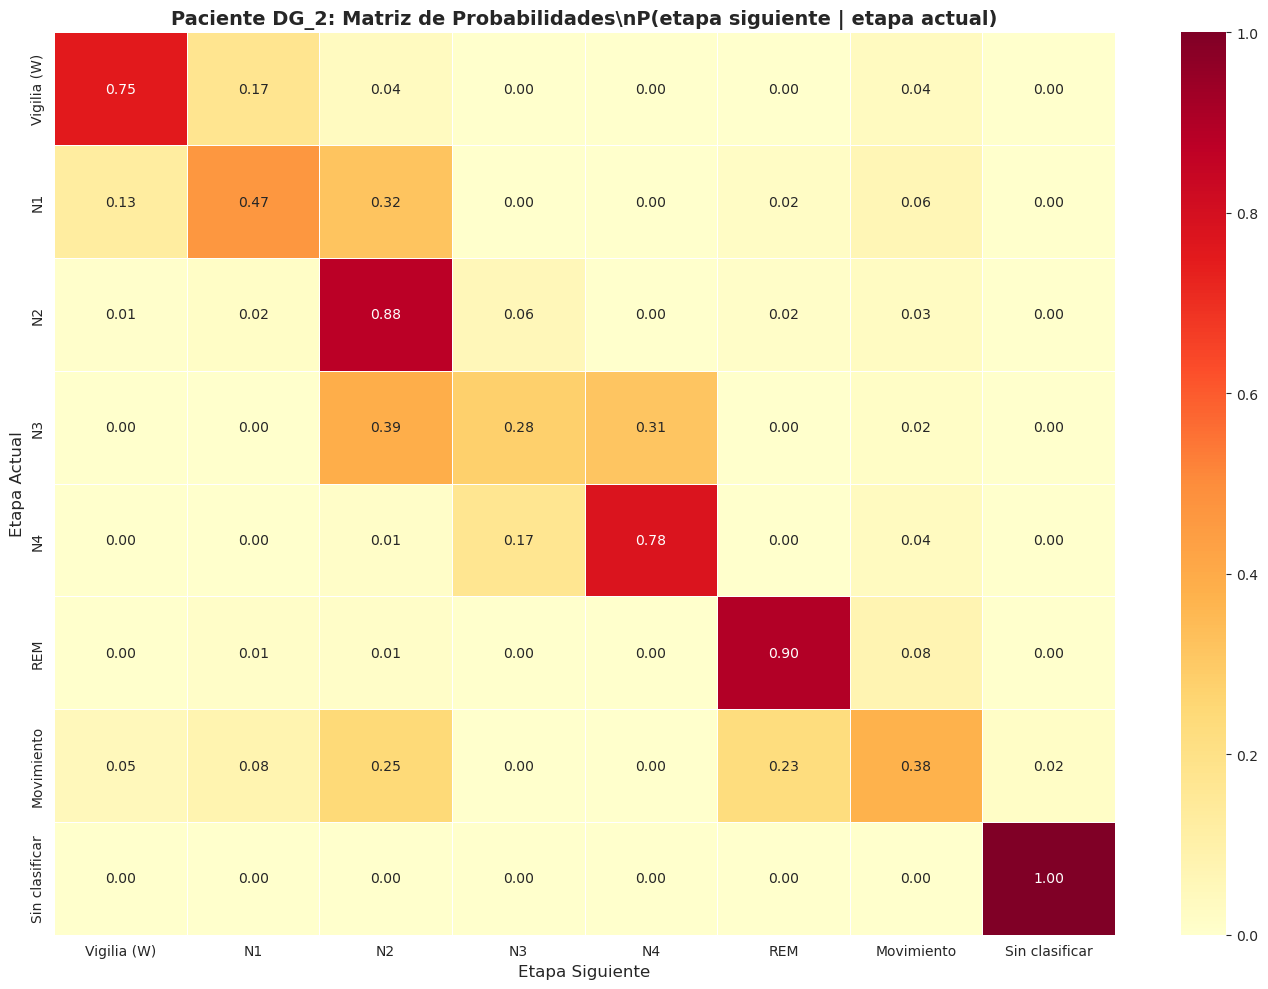


Paciente: DG_2
Épocas: 1055 | Bigramas: 1054 | Transiciones: 34


In [4]:
# Analizar paciente AR_2
resultados = generar_reporte_completo("DG_2")


In [5]:
# Pacientes disponibles
import os
archivos = [f for f in os.listdir('../Datos/') if f.startswith('Scoring_') and f.endswith('_2')]
pacientes = sorted([f.replace('Scoring_', '').replace('_2', '') for f in archivos])
print(f"Pacientes disponibles: {pacientes}")

# Para analizar otro paciente:
# resultados = generar_reporte_completo("DG_2")
# resultados = generar_reporte_completo("EL_2")


Pacientes disponibles: ['AR', 'DG', 'EL', 'GA', 'IN', 'JS', 'LL', 'SS', 'VB', 'VC']


## Procesar Todos los Pacientes

Función para procesar todos los pacientes y obtener datos consolidados.

In [6]:
# Procesar todos los pacientes
datos_todos = procesar_todos_pacientes()

# Ver métricas consolidadas
print("\nMÉTRICAS DE TODOS LOS PACIENTES:")
print(datos_todos['dataframe_metricas'])

# Ver matriz promedio
print("\nMATRIZ DE TRANSICIÓN PROMEDIO:")
print(datos_todos['matriz_promedio'].round(3))


Procesando 10 pacientes...
  ✓ AR
  ✓ DG
  ✓ EL
  ✓ GA
  ✓ IN
  ✓ JS
  ✓ LL
  ✓ SS
  ✓ VB
  ✓ VC

Procesamiento completado: 10 pacientes

MÉTRICAS DE TODOS LOS PACIENTES:
  Paciente  Épocas  Duración_min  Bigramas  Transiciones_únicas  Etapa_0  \
0       AR     977         488.5       976                   29        8   
1       DG    1055         527.5      1054                   34       52   
2       EL     947         473.5       946                   34       26   
3       GA    1023         511.5      1022                   32       23   
4       IN     981         490.5       980                   33        7   
5       JS    1042         521.0      1041                   30        6   
6       LL     894         447.0       893                   34       51   
7       SS     906         453.0       905                   30       61   
8       VB     836         418.0       835                   29       76   
9       VC     840         420.0       839                   27      

In [7]:
# Acceder a un paciente específico
paciente_ar = datos_todos['datos_completos']['DG']["matriz_absoluta"]

print(paciente_ar)

    0   1    2   3   4    5   6   7
0  39   9    2   0   0    0   2   0
1   6  22   15   0   0    1   3   0
2   3   8  401  26   0    7  13   0
3   0   0   21  15  17    0   1   0
4   0   0    1  13  60    0   3   0
5   0   3    3   0   0  189  16   0
6   3   5   15   0   0   14  23   1
7   0   0    0   0   0    0   0  94
